# Scraping Job Posts from Indeed.com

In [ ]:
Import Packages Needed for Scraping

In [46]:
from BeautifulSoup import BeautifulSoup
from urllib import urlopen
import re
import time
import pandas as pd
from datetime import date, datetime, timedelta
import csv
import enchant

Import csv which contains Top 1,000 most populous US cities

In [2]:
cities = open('largest_us_cities.tsv', 'r')
largest_cities = map(lambda y: y.split('\t'), map(lambda x: x.split('\n')[0], cities))
cities.close()
largest_cities_formatted = map(lambda z: [z[1]+', '+z[2],
        str(z[1].replace(' ','+')+'%2C+'+z[2].replace(' ','+'))], largest_cities)

In [3]:
def extractJK(job):
    return job[job.find('jk:')+4:job.find('efccid:')-2]

def extractCMP(job):
    return job[job.find('cmp:')+5:job.find('cmpesc:')-2]
    
def extractTitle(job):
    return job[job.find('title:')+7: job.find('locid:')-2]

def extractBundle(job):
    return [extractJK(job),
            extractCMP(job),
            extractTitle(job)]

Job which scrapes the job search result pages for result metadata

In [4]:
job_searches = [['data scientist','analysis'],
                ['data analyst','analysis'],
                ['data engineering','engineering'],
                ['statistician','analysis'],
                ['big data analyst','engineering'],
                ['data strategist','bus. strategy and admin.'],
                ['intelligence analyst','analysis'],
                ['reporting analyst','analysis'],
                ['analytics office','bus. strategy and admin.'],
                ['operations resarch analyst','analysis'],
                ['management science','bus. strategy and admin.'],
                ['applied mathematician','analysis'],
                ['etl engineer','engineering'],
                ['business strategist','bus. strategy and admin.'],
                ['data qa','engineering'],
                ['data modeling','engineering'],
                ['business analyst','analysis'],
                ['digital analyst','analysis'],
                ['research analyst','analysis'],
                ['database administrator','engineering'],
                ['data infrustructure','engineering'],
                ['data project management','bus. strategy and admin.'],
                ['data project management','bus. strategy and admin.'],
                ['data ops','analysis'],
                ['data visualization','engineering'],
                ['analytics associate','analysis'],
                ['data coordinator', 'bus. strategy and admin.'],
                ['database analyst', 'engineering'],
                ['data warehousing specialist','engineering'],
                ['nosql analyst','engineering'] ]
len(job_searches)

30

In [5]:
all_jobs = []

for job_search in job_searches:
    for city in largest_cities_formatted:
        print(city[0])
        search_term = job_search[0]
        search = search_term.replace(' ','+')
        location = city[1]
        radius = 0
        since = 7
        link = "http://www.indeed.com/jobs?as_and={job_title}&l={loc}&radius=0&fromage={since}&filter=0&limit=100&sort=date".format(job_title = search, loc=location, since = since)
        html = str(urlopen(link).read())
        soup = BeautifulSoup(html)

        page_jobs = str(soup.find(id = "searchCount"))

        #Handle the possibility that there are no search results!
        try:
            start_end_range = [int(page_jobs.split(' ')[2].replace(',', '')),
                           int(page_jobs.split(' ')[4].replace(',', '')),
                           int(page_jobs.split(' ')[6].replace(',', '').replace('</div>', ''))]
        except IndexError:
                start_end_range = [0,0,0]

        #Loop through the search results 100 jobs at a time
        while (start_end_range[0] < start_end_range[2]) and (start_end_range[0] < 1100):
            #Extract company metadata set 1: job_id, company, location, country, zip, city, job_title
            scripts = list(map(lambda x: str(x), soup.findAll('script')))
            job_map = list(filter(lambda x: "jobmap[" in x, scripts))
            split_text = job_map[0].split('\n\n')
            jobs = split_text[2:len(split_text)]
            job_ids = list(map(lambda x: extractBundle(x)+[city[0]]+job_search+['http://www.indeed.com/viewjob?jk='+extractBundle(x)[0]], jobs))

            #append jobs from current result page into the master jobs list
            all_jobs += job_ids

            if start_end_range[0] < start_end_range[2]:
                #print(link)
                #print(start_end_range)
                link = "http://www.indeed.com/jobs?as_and={job_title}&l={loc}&radius=0&fromage={since}&filter=0&limit=100&sort=date&start=".format(job_title = search, loc=location, since=since)+str(start_end_range[0]+99)
                time.sleep(0.5)
                html = str(urlopen(link).read())
                soup = BeautifulSoup(html)
                page_jobs = str(soup.find(id = "searchCount"))
                start_end_range[0] += 100
                start_end_range[1] += 100

#standard list deduplication
#Data Table: all_jobs_dedup --> job_search_result
all_jobs_dedup = []
for job in all_jobs:
    if job not in all_jobs_dedup and job[0]:
        all_jobs_dedup.append(job)

New York, New York
Los Angeles, California
Chicago, Illinois
Houston, Texas
Philadelphia, Pennsylvania
Phoenix, Arizona
San Antonio, Texas
San Diego, California
Dallas, Texas
San Jose, California
Austin, Texas
Jacksonville, Florida
San Francisco, California
Indianapolis, Indiana
Columbus, Ohio
Fort Worth, Texas
Charlotte, North Carolina
Seattle, Washington
Denver, Colorado
El Paso, Texas
Detroit, Michigan
Washington, District of Columbia
Boston, Massachusetts
Memphis, Tennessee
Nashville-Davidson, Tennessee
Portland, Oregon
Oklahoma City, Oklahoma
Las Vegas, Nevada
Baltimore, Maryland
Louisville/Jefferson County, Kentucky
Milwaukee, Wisconsin
Albuquerque, New Mexico
Tucson, Arizona
Fresno, California
Sacramento, California
Kansas City, Missouri
Long Beach, California
Mesa, Arizona
Atlanta, Georgia
Colorado Springs, Colorado
Virginia Beach, Virginia
Raleigh, North Carolina
Omaha, Nebraska
Miami, Florida
Oakland, California
Minneapolis, Minnesota
Tulsa, Oklahoma
Wichita, Kansas
New Orlea

KeyboardInterrupt: 

Create a Pandas Dataframe of job metadata

In [6]:
#Data Table: all_jobs_dedup --> job_search_result
all_jobs_dedup = []
for job in all_jobs:
    if job not in all_jobs_dedup and job[4] in ['data scientist','data analyst','data engineering']:
        all_jobs_dedup.append(job)

In [7]:
len(all_jobs_dedup)

111194

In [8]:
all_jobs_df = pd.DataFrame(all_jobs_dedup, columns=('job_id','company','job_title','searched_city','search_term','search_category','url'))
all_jobs_df.head(10)

,job_id,company,job_title,searched_city,search_term,search_category,url
0,e60f9cd9080eca9f,NBCUniversal,"Research Analyst, VOD","New York, New York",data scientist,analysis,http://www.indeed.com/viewjob?jk=e60f9cd9080eca9f
1,929d17d9c5435bc1,GinasTechJobs.com,Quantitative Analyst,"New York, New York",data scientist,analysis,http://www.indeed.com/viewjob?jk=929d17d9c5435bc1
2,e2e0325cfd4ff3ad,Weill Cornell Medical College,Operations Administrator,"New York, New York",data scientist,analysis,http://www.indeed.com/viewjob?jk=e2e0325cfd4ff3ad
3,d5e8e55d5f8c1e80,NYU Langone Medical Center,Revenue Cycle Analyst,"New York, New York",data scientist,analysis,http://www.indeed.com/viewjob?jk=d5e8e55d5f8c1e80
4,0024b7ca712718f9,Weill Cornell Medical College,Revenue Cycle Coding Specialist,"New York, New York",data scientist,analysis,http://www.indeed.com/viewjob?jk=0024b7ca712718f9
5,40ceb34d9d727b23,NYU Langone Medical Center,Senior Ultrasound Technician,"New York, New York",data scientist,analysis,http://www.indeed.com/viewjob?jk=40ceb34d9d727b23
6,d497ffc85d272d42,Wunderman,Senior Project Manager - Rx,"New York, New York",data scientist,analysis,http://www.indeed.com/viewjob?jk=d497ffc85d272d42
7,90a8a39dadb92a90,"DB Healthcare, Inc.",HPC Technology Specialist I - NY,"New York, New York",data scientist,analysis,http://www.indeed.com/viewjob?jk=90a8a39dadb92a90
8,0e8649f0518c1b49,Weill Cornell Medical College,Scientific Administrator,"New York, New York",data scientist,analysis,http://www.indeed.com/viewjob?jk=0e8649f0518c1b49
9,9e7565b7111d11ef,Capital One,"Sr. Product Manager, Digital Product Management","New York, New York",data scientist,analysis,http://www.indeed.com/viewjob?jk=9e7565b7111d11ef


/Users/benjaminnichols/python_playground/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


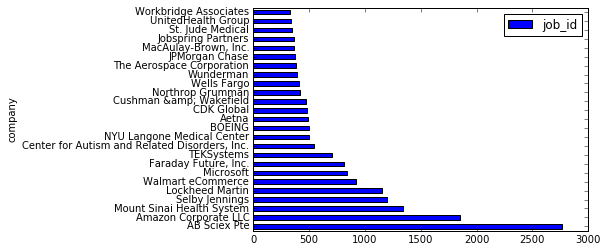

In [10]:
%matplotlib inline
top_companies = pd.DataFrame(all_jobs_df.groupby('company')['job_id'].count()).sort('job_id', ascending=False)
top_companies.head(25).plot(kind = 'barh')

Write to csv the results of the scrape

In [60]:
with open('jobs.csv', 'w') as csvfile:
    jobwriter = csv.writer(csvfile)
    
    for job in all_jobs_dedup:
        jobwriter.writerow(job)

In [27]:
depuped_job_ids

[]

In [42]:
top_cities = ['Kearny, New Jersey',
'Passaic, New Jersey',
'New Rochelle, New York',
'East Orange, New Jersey',
'Freeport, New York',
'West New York, New Jersey',
'Mount Vernon, New York',
'Union City, New Jersey',
'Hempstead, New York',
'Elizabeth, New Jersey',
'Linden, New Jersey',
'Martinez, California',
'Revere, Massachusetts',
'Everett, Massachusetts',
'Shoreline, Washington',
'Daly City, California',
'Bayonne, New Jersey',
'Burien, Washington',
'Valley Stream, New York',
'New York, New York',
'Berwyn, Illinois']

In [26]:
import csv

In [43]:
depuped_job_ids = []
data = open('/Users/benjaminnichols/Downloads/python-getting-started/data_tables/job_search_result.csv','r')
csv_file = csv.reader(data)
for line in csv_file:
    if line[0] not in depuped_job_ids and line[3] in top_cities:
        depuped_job_ids.append(line[0])
#data.close()

In [44]:
len(depuped_job_ids)

6523

In [50]:
all_jobs_deduped = []
data = open('/Users/benjaminnichols/Downloads/python-getting-started/data_tables/job_search_result.csv','r')
csv_file = csv.reader(data)
for line in csv_file:
    all_jobs_deduped.append(line)
#data.close()

In [51]:
all_jobs_deduped

[['e60f9cd9080eca9f',
  'NBCUniversal',
  'Research Analyst, VOD',
  'New York, New York',
  'data scientist',
  'analysis',
  'http://www.indeed.com/viewjob?jk=e60f9cd9080eca9f'],
 ['929d17d9c5435bc1',
  'GinasTechJobs.com',
  'Quantitative Analyst',
  'New York, New York',
  'data scientist',
  'analysis',
  'http://www.indeed.com/viewjob?jk=929d17d9c5435bc1'],
 ['e2e0325cfd4ff3ad',
  'Weill Cornell Medical College',
  'Operations Administrator',
  'New York, New York',
  'data scientist',
  'analysis',
  'http://www.indeed.com/viewjob?jk=e2e0325cfd4ff3ad'],
 ['d5e8e55d5f8c1e80',
  'NYU Langone Medical Center',
  'Revenue Cycle Analyst',
  'New York, New York',
  'data scientist',
  'analysis',
  'http://www.indeed.com/viewjob?jk=d5e8e55d5f8c1e80'],
 ['0024b7ca712718f9',
  'Weill Cornell Medical College',
  'Revenue Cycle Coding Specialist',
  'New York, New York',
  'data scientist',
  'analysis',
  'http://www.indeed.com/viewjob?jk=0024b7ca712718f9'],
 ['40ceb34d9d727b23',
  'NYU L

Extract all job descripts, post date, company ratings from the search results scrape

In [47]:
#depuped_job_ids = list(set(list(map(lambda x: x[0], all_jobs_dedup))))

def extractDatePosted(detail):
    if detail[0] not in str(range(10)):
        return date.today()
    elif detail[0:1] in str(range(100)):
        return date.today() - timedelta(days=int(detail[0:1]))
    elif detail[0] in str(range(10)):
        return date.today() - timedelta(days=int(detail[0]))
    else:
        datetime(9999,12,31)

def GetCompany(job_id):
    return map(lambda y: y[1], list(filter(lambda x: x[0] == job_id, all_jobs_dedup)))[0]
        
job_details = []
counter = 1
for job in depuped_job_ids:
    #time.sleep(0.5)
    print(counter)
    try:
        link = "http://www.indeed.com/viewjob?jk={job_id}".format(job_id=job)
        html = str(urlopen(link).read())
        soup = BeautifulSoup(html)
        
        #identify the job description text body
        class_summary = list(map(lambda x: str(x), soup.findAll("span", {"class": "summary"})))
        job_summary = str.lower(class_summary[0][class_summary[0].find('class="summary">')+16:class_summary[0].find('</span>')])

        replace_web_char = ['<b>','</b>','<br />','<li>','</li>','<ul>','</ul>','<em>','</em>']
        for char in replace_web_char:
            job_summary = job_summary.replace(char, '')
        
        try:
            #identify the company rating
            class_rating = list(map(lambda x: str(x), soup.findAll("span", {"class": "rating"})))
            rating = float(class_rating[0][class_rating[0].find('width')+7:class_rating[0].find('px;"><')])/0.6

            #identify the company ratings review count
            class_nounderline = list(map(lambda x: str(x), soup.findAll("span", {"class": "slNoUnderline"})))
            rating_count = int((class_nounderline[0][class_nounderline[0].find('"slNoUnderline"')+16:class_nounderline[0].find('reviews')-1]).replace(',',''))
        except IndexError:
            rating = 0.0
            rating_count = 0
        
        #identify the date the post was made
        class_date = list(map(lambda x: str(x), soup.findAll("span", {"class": "date"})))
        date_posted = extractDatePosted(class_date[0][class_date[0].find('date')+6:class_date[0].find('</')])
        
        #create a list of 
        rating_and_count = [job, job_summary, rating, rating_count, date_posted]
    except IndexError:
        rating_and_count = [job,'',0.0, 0, datetime(9999,12,31)]

    job_details.append(rating_and_count)
    counter += 1
    
#Data Table: company_details
company_details = list(map(lambda x: [GetCompany(x[0]),round(x[2],2),x[3]], job_details))
#Data Table: job_post
job_post = list(map(lambda x: [x[0],x[1],x[4]], job_details))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


NameError: global name 'all_jobs_dedup' is not defined

In [57]:
def GetCompany(job_id):
    return map(lambda y: y[1], list(filter(lambda x: x[0] == job_id, all_jobs_deduped)))[0]

#Data Table: company_details
company_details = list(map(lambda x: [GetCompany(x[0]),round(float(x[2]),2),x[3]], job_details))
#Data Table: job_post
job_post = list(map(lambda x: [x[0],x[1],x[4]], job_details))

In [58]:
all_details_df = pd.DataFrame(job_details, columns=('job_id','summary','rating','count','date_posted'))
all_details_df.head(5)

,job_id,summary,rating,count,date_posted
0,e60f9cd9080eca9f,about us\n\nnbcuniversal is one of the world’s...,86.0,1004,2016-11-07
1,929d17d9c5435bc1,quantitative analyst\n\n\nwill relocate the ri...,0.0,0,2016-11-08
2,e2e0325cfd4ff3ad,position summary\n\n\nreporting to the departm...,86.0,138,2016-11-07
3,d5e8e55d5f8c1e80,"nyu langone medical center, a world-class, pat...",86.0,176,2016-11-07
4,0024b7ca712718f9,position summary\n\n\nthis position is respons...,86.0,138,2016-11-07


In [35]:
with open('company.csv', 'w') as csvfile:
    jobwriter = csv.writer(csvfile)
    
    for company in company_ratings:
        jobwriter.writerow(company)

Create a function for Tokenizing the words in the job summary

In [62]:
def tokenize(text_body):
    text_body = str.lower(text_body)
    #replace most non-alpha characters
    replace_grammar_char = ['0','1','2','3','4','5','6','7','8','9',',',';','?','!','.','+','(',')','[',']','{','}','\n','%','/','#','~','<','>','*','&','=','|','"','@',':']
    for char in replace_grammar_char:
        text_body = text_body.replace(char, ' ')
    text_body_words = text_body.split(' ')
    text_body_words = list(filter(lambda x: x != '', text_body_words))
    
    #import the top words .txt
    document = open('top_1000_words.txt','r')
    top_1000_words = []
    for word in document:
        top_1000_words.append(word)
    document.close()
    top_1000_words = map(lambda x: x.replace('\n',''), top_1000_words)
    
    #import english dictionary for lookup purposes
    d = enchant.Dict("en_US")
    
    #remove words which are in the top 200 words and are less than 3 charatcers long
    relevant_words = list(filter(lambda x: x not in top_1000_words[:200] and len(x)>2 and d.check(x) == True, text_body_words))
    
    #create a dictionary of relevant words and their count
    tokens = {}
    for word in relevant_words:
        if word not in tokens:
            tokens[word] = 0
        tokens[word] += 1

    return tokens

In [63]:
#Data Table: job_tokens
job_tokens = []
job_token_map = list(map(lambda x: [x[0],tokenize(x[1])],job_post))

for job in job_token_map:
    for word in job[1]:
        job_tokens.append([job[0],word,job[1][word]])

Data Tables:
1. job_search_result
2. company_details
3. job_details
4. job_tokens

In [11]:
#data table (1): job_search_result
job_search_result = all_jobs_dedup

with open('/Users/benjaminnichols/Downloads/python-getting-started/data_tables/job_search_result.csv', 'w') as csvfile:
    jobwriter = csv.writer(csvfile)
    
    for line in job_search_result:
        jobwriter.writerow(line)

In [59]:
#data table (2): company_details

with open('/Users/benjaminnichols/Downloads/python-getting-started/data_tables/company_details.csv', 'w') as csvfile:
    jobwriter = csv.writer(csvfile)
    
    for line in company_details:
        jobwriter.writerow(line)

In [65]:
#data table (3): job_post

with open('/Users/benjaminnichols/Downloads/python-getting-started/data_tables/job_post.csv', 'w') as csvfile:
    jobwriter = csv.writer(csvfile)
    
    for line in job_post:
        jobwriter.writerow([line[0],line[2]])

In [64]:
#data table (4): job_tokens

with open('/Users/benjaminnichols/Downloads/python-getting-started/data_tables/job_tokens.csv', 'w') as csvfile:
    jobwriter = csv.writer(csvfile)
    
    for line in job_tokens:
        jobwriter.writerow(line)